## Data Loading and Exploratory Analysis

In [1]:
import json
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

In [2]:
# Change directory and read in the data
path = '/Users/student/Desktop/SpringboardDSCareerTrack/ultimate_challenge'
os.chdir(path)
login_data = pd.read_json('logins.json')
# Sort the time stamp in ascending order
login_data.sort_values(by='login_time', inplace=True)
login_data

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
...,...
93136,1970-04-13 18:48:52
93137,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93141,1970-04-13 18:54:23


In [3]:
# Aggregate login counts in 15 min intervals from first login to last login
login_data['login_count'] = [1]*len(login_data)
fifteen_min_Int = login_data.set_index('login_time').resample('15T').sum()

#### Line plot function

In [4]:
# Function that will build lineplot
def lineplot(x, y, title, xlabel_rot, xlabels):
    plt.figure(figsize=(10,6))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabels)
    plt.xticks(rotation=xlabel_rot)
    plt.show()

#### Overall login trends from 1/1/1970 to 4/13/1970

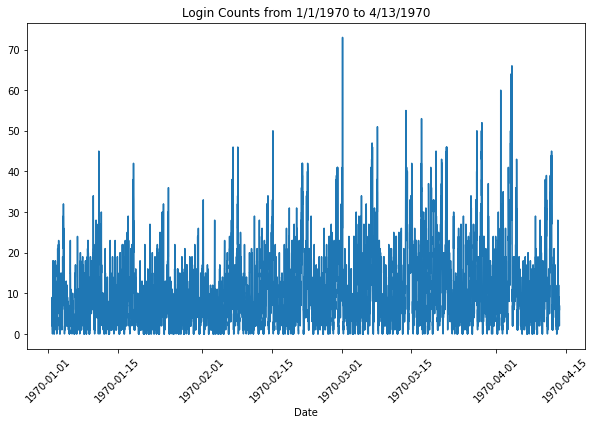

In [5]:
lineplot(fifteen_min_Int.index, fifteen_min_Int.login_count, 
         'Login Counts from 1/1/1970 to 4/13/1970', 45, 'Date')

While the plot is messy with many points, we see that the time series is seasonal with peaks at certain hours, or days. Let's explore these further.

#### Average Login per hour

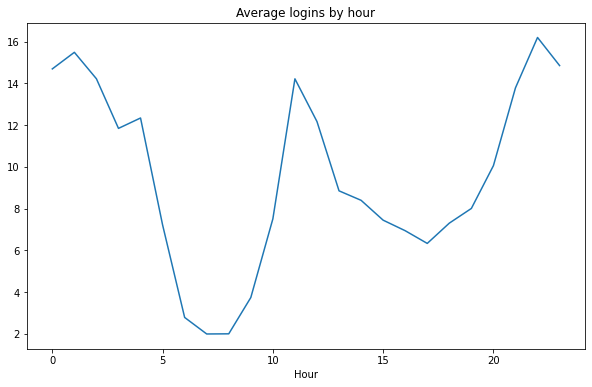

In [6]:
# First reset index
fifteen_min_Int.reset_index(inplace=True)
# Extract the hour from login time
fifteen_min_Int['hour'] = fifteen_min_Int['login_time'].dt.hour

# Obtain dataframe for average hour logins
avg_hourly_logins = fifteen_min_Int.groupby('hour')['login_count'].mean()

# Plot the average logins by hour 
lineplot(list(avg_hourly_logins.index), list(avg_hourly_logins.values), 
         'Average logins by hour', 0, 'Hour')

In the 24 hours within a day, users seem to login at two major intervals: Early morning from approximately 12am to 2am. There is another peak around 11am to 12pm. 

#### Average Login per day of week

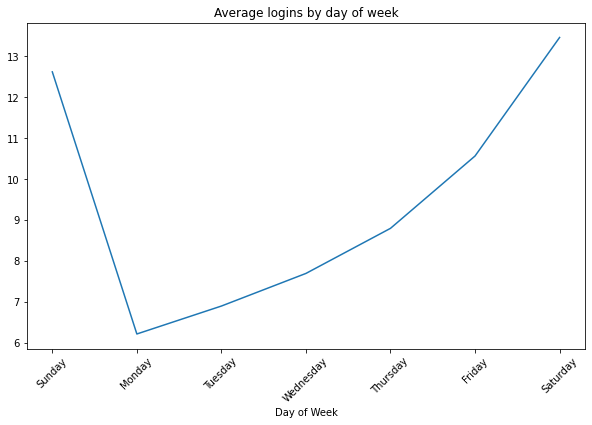

In [7]:
# Obtain the day of week from datetime values
fifteen_min_Int['dayOfWeek'] = fifteen_min_Int['login_time'].dt.day_name()

# Save new dataframe of average daily login
avg_dayOfWeek_login = fifteen_min_Int.groupby('dayOfWeek')['login_count'].mean()

# Due to the order of the days in our dataframe not being in order, we will use a for loop 
# to store the days in correct order with their respective average login value
dayOfWeek_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dayOfWeek_login =[]

for i in range(len(dayOfWeek_order)):
    j = 0
    while j < len(dayOfWeek_order):
        if list(avg_dayOfWeek_login.index)[j] == dayOfWeek_order[i]:
            dayOfWeek_login.append(avg_dayOfWeek_login[j])
            break
        else:
            j += 1

# Plot the average logins by hour 
lineplot(dayOfWeek_order, dayOfWeek_login, 
         'Average logins by day of week', 45, 'Day of Week')

Users increasingly login building up to the weekend. We see the lowest login times on Monday which could be due to a new work week and figuring out other tasks or schedules for the week. As the week goes on, users on average, log in more and hits a peak during the weekend.

#### Multiple lineplot Function

In [8]:
# This function will plot multiple lineplots on one chart
def multilineplots(days_list, days_title_list, title, xlabel):
    plt.subplots(figsize=(10,6)) # fig, ax =
    
    for i in range(len(days_list)):
        plt.plot(list(days_list[i].index), list(days_list[i].values))
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend(days_title_list)
    plt.show()

#### Average hourly logins during weekday

In [9]:
# Obtain average hourly logins for each weekday, Monday through Friday.
mon = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Monday'].groupby('hour')['login_count'].mean()
tues = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Tuesday'].groupby('hour')['login_count'].mean()
wed = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Wednesday'].groupby('hour')['login_count'].mean()
thrs = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Thursday'].groupby('hour')['login_count'].mean()
fri = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Friday'].groupby('hour')['login_count'].mean()

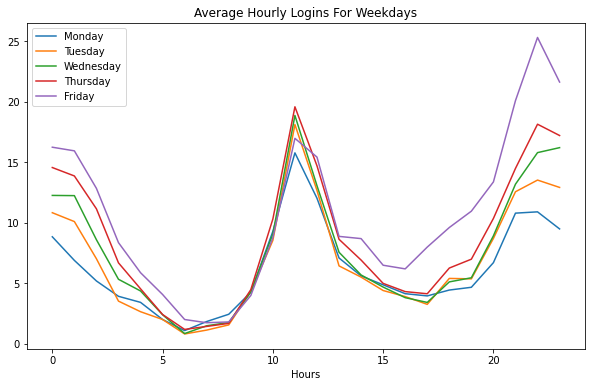

In [10]:
# Use multilineplots function to plot average hourly logins on weekdays
multilineplots([mon, tues, wed, thrs, fri], 
               ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 
               'Average Hourly Logins For Weekdays', 'Hours')

There are two notable observations. 

1. On weekdays, users tend to log in close to midday and late at night around 10pm. This makes sense since you don't want to stay up too late on a weekday.
2. As the week goes on, we see more people logging in later at night. Look at Friday and you see the highest peak.

#### Average hourly logins during weekend

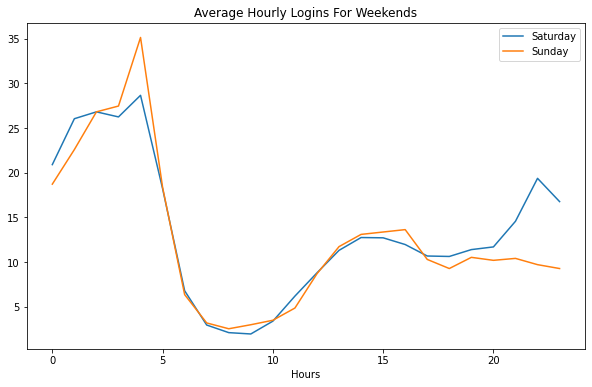

In [11]:
# Obtain average hourly logins for each weekend, Saturday and Sunday.
sat = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Saturday'].groupby('hour')['login_count'].mean()
sun = fifteen_min_Int[fifteen_min_Int['dayOfWeek']=='Sunday'].groupby('hour')['login_count'].mean()

# Use multilineplots function to plot average hourly logins on Saturday and Sunday
multilineplots([sat, sun], 
               ['Saturday', 'Sunday'], 
               'Average Hourly Logins For Weekends', 'Hours')

In contrast to the weekday, we see that the users tend to log in later at night and then even remain staying logged in, into the early mornings. There isn't the noon peak like during the weekday. 

## Experiment and Metrics Design

#### Key Metric

1. The key measure of success for this experiment is to determine if the supposed increase in number of rider logins for Ultimate transportation services will offset the toll costs that Ultimate must reimburse. The only manner in which profit margins increase is to have a significant enough increase in rider logins because of the new deal.   

#### Experiment

1. Form two groups of designated drivers. One group that works within the designated city limits and another experimental group that will pay the tolls to go move from one city to the other. 

2. We will compare the average revenue generated from both groups. We propose the null hypothesis as "The 'paying toll' group will not generate more average revenue than our original group."

3. We use the one tailed hypothesis test and a p-value threshold (e.g. 0.05) and see if the calculated p-value is smaller than our threshold. If that is the case, we will reject the null hypothesis and deduce that paying the tolls could be a viable business model. 

4. We can find a pre-determined sales increase threshold to indicate how effective our new business idea is. For instance, if the 'paying toll' produces sales 15% greater than our original group, then a certain % of the ride providers should be designated to inter-city ride provision. We would need to consult with management and financial team for specific metrics.

5. Another option could be have more rides that pay for toll available during the weekends, if people want to travel to the other town for a weekend, and therefore enable transportation then.

## Predictive Modeling

In [12]:
# Read in the dataset
ultimate_df = pd.read_json('ultimate_data_challenge.json')
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
# Find out which features have missing values
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


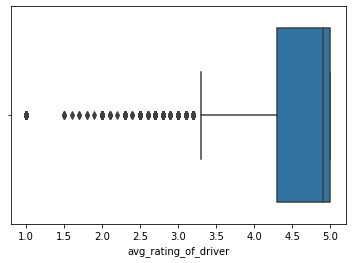

In [14]:
# Plot boxplot for 'avg_rating_of_driver'. If many outliers, use median to fill missing values
sns.boxplot(ultimate_df.avg_rating_of_driver)

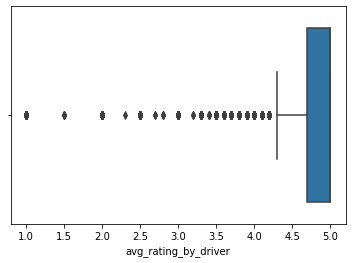

In [15]:
# Plot boxplot for 'avg_rating_by_driver'. If many outliers, use median to fill missing values
sns.boxplot(ultimate_df.avg_rating_by_driver)

In [16]:
# Fill avg_rating_of_driver with the median value
ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median(), 
                                           inplace=True)

# Fill the missing phone value with other. This feature likely will not be that useful
ultimate_df['phone'] = ultimate_df['phone'].fillna('Other')

# Fill avg_rating_by_driver with the median value
ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].median(), 
                                           inplace=True)

In [17]:
# Ensure no missing values
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We will now build our predictior variable 'retained'. To do this, we get the latest day within the 'last_trip_date' feature by assuming that is when this dataset was extracted. We will use this date as a reference point to see if other users rode within the last 31 days (approximately a month). If they did, we give a 'retained' value of 1. Else, 0. 

In [18]:
# Turn the date features into datetime values
ultimate_df['signup_date'] =  pd.to_datetime(ultimate_df['signup_date'], format='%Y-%m-%d')
ultimate_df['last_trip_date'] =  pd.to_datetime(ultimate_df['last_trip_date'], format='%Y-%m-%d')

# Obtain the last date from 'last_trip_date'
last_date = max(ultimate_df['last_trip_date'])

In [19]:
# Verify when the last date was.
last_date

Timestamp('2014-07-01 00:00:00')

In [20]:
# Build a 'last_used_inDays' feature that tells how many days prior to 07/01/2014 that the
# user used Ultimate
ultimate_df['last_used_inDays'] = (last_date - ultimate_df['last_trip_date']).dt.days

In [21]:
# Build a 'retained' feature which will be the predictor variable. If user did use 
# Ultimate within the past 31 days, give a 'retained' value of 1. Otherwise, 0.
ultimate_df['retained'] = 0
ultimate_df.loc[ultimate_df['last_used_inDays'] <= 31, 'retained'] = 1

In [22]:
ultimate_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_used_inDays,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,26,1
49996,Astapor,1,2014-01-24,4.9,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,157,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,40,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,167,0


In [23]:
# Drop the dates and last_used_inDays as no longer relevant
ultimate_df.drop(['signup_date', 'last_trip_date', 'last_used_inDays'], axis=1, inplace=True)

In [24]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  retained                50000 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


#### Feature Selection

For feature selection, we use two statistical tools. 

1. The independent ttest will be used for numerical features. We compare the averages between the 'retained' and not retained group and verify if they are different. If the output p-value is less than 5%, we assume the averages are different and therefore an important feature for model prediction. 

2. The chi-square test will be used for categorical variables. We see if the frequency distributions of the feature for the retaind and non-retained group. If the output p-value is greater than 5%, we conclude the frequencies do not match and therefore an important indicator for model prediction.

In [25]:
# Function that will perform indepdent ttest between the retained and nonretained group
def independent_ttest(var_name, data):
    retained = data[data['retained']==1][var_name]
    nonretained = data[data['retained']==0][var_name]
    print('Retained mean for', var_name, ':' ,retained.mean(), ', std:', retained.std()) 
    print('Non-retained mean for ', var_name, ': ', nonretained.mean(), ', std:', nonretained.std())
    return scipy.stats.ttest_ind(retained, nonretained, equal_var = False)

In [26]:
# Function that will perform chi-square test between the retained and nonretained group
def chisquare(var_name,data):
    # This code block will create a barplot for categorical variable.
    retained = data[data['retained']==1]
    nonretained = data[data['retained']==0]
       
    # This code block will create two dictionaries for defaulters and nondefaulters for specified variable. It will obtain
    # percentage for each categorical value which we can use in chi-square test to see if there is difference in their distribution.
    var_name_values = list(data[var_name].unique())
    exp_freq = {}; obs_freq = {}
    
    for val in var_name_values:
        if val not in list(retained[var_name].unique()):
            obs_freq[val] = 0
        else:
            obs_freq[val] = retained[retained[var_name] == val][var_name].count()/len(retained)
            
    for val in var_name_values:
        if val not in list(nonretained[var_name].unique()):
            exp_freq[val] = 0
        else:
            exp_freq[val] = nonretained[nonretained[var_name] == val][var_name].count()/len(nonretained)
            
    
    return print('Chi-square test results:',scipy.stats.chisquare(list(obs_freq.values()), list(exp_freq.values()) ) )            # do chi-square on dictionary values

In [27]:
# Ind ttest for 'avg_rating_of_driver'
independent_ttest('avg_rating_of_driver', ultimate_df)

Retained mean for avg_rating_of_driver : 4.61988763460438 , std: 0.526675127673384
Non-retained mean for  avg_rating_of_driver :  4.668869610422794 , std: 0.6033973646802948


Ttest_indResult(statistic=-9.558514501472972, pvalue=1.2526947107067146e-21)

In [28]:
# Ind ttest for 'surge_pct'
independent_ttest('surge_pct', ultimate_df)

Retained mean for surge_pct : 9.124132549550055 , std: 15.60567311404824
Non-retained mean for  surge_pct :  8.678025798485827 , std: 22.248277526589344


Ttest_indResult(statistic=2.6309015074040327, pvalue=0.008518517326658244)

In [29]:
# Ind ttest for 'avg_surge'. P-Value too high. WILL EXCLUDE FROM MODEL.
independent_ttest('avg_surge', ultimate_df)

Retained mean for avg_surge : 1.0736378296832096 , std: 0.1628110393425536
Non-retained mean for  avg_surge :  1.0754670695649493 , std: 0.25249277817551097


Ttest_indResult(statistic=-0.9847753787087382, pvalue=0.3247391871560671)

In [30]:
# Ind ttest for 'weekday_pct'. P-Value too high. WILL EXCLUDE FROM MODEL
independent_ttest('weekday_pct', ultimate_df)

Retained mean for weekday_pct : 61.15901264110692 , std: 29.575211244857158
Non-retained mean for  weekday_pct :  60.78059914871481 , std: 41.07957708428638


Ttest_indResult(statistic=1.1946589375763428, pvalue=0.2322260931950641)

In [31]:
# Ind ttest for 'avg_dist'
independent_ttest('avg_dist', ultimate_df)

Retained mean for avg_dist : 5.117293866722204 , std: 4.635886807267895
Non-retained mean for  avg_dist :  6.2212558079084985 , std: 6.247261400429541


Ttest_indResult(statistic=-22.600043146674942, pvalue=1.6522927009576263e-112)

In [32]:
# Ind ttest for 'avg_rating_by_driver'
independent_ttest('avg_rating_by_driver', ultimate_df)

Retained mean for avg_rating_by_driver : 4.763491650626866 , std: 0.32836450219478747
Non-retained mean for  avg_rating_by_driver :  4.788767586184457 , std: 0.5055034704092815


Ttest_indResult(statistic=-6.776651896638888, pvalue=1.2435433355149445e-11)

In [33]:
# Chisquare test for 'city'
chisquare('city', ultimate_df)

Chi-square test results: Power_divergenceResult(statistic=0.44758589930921977, pvalue=0.7994806499784526)


In [34]:
# Chisquare test for 'phone'
chisquare('phone', ultimate_df)

Chi-square test results: Power_divergenceResult(statistic=0.18830208953713054, pvalue=0.9101452791749256)


In [35]:
# Create dummy variables for city, phone and ultimate_black_user
ultimate_df = pd.get_dummies(ultimate_df, columns=['city', 'ultimate_black_user', 'phone'])
ultimate_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,ultimate_black_user_False,ultimate_black_user_True,phone_Android,phone_Other,phone_iPhone
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0,0


In [37]:
# Build our train and test sets
X = ultimate_df.drop(['retained', 'weekday_pct', 'avg_surge'], axis=1)
y = ultimate_df['retained']   # this is our predictor variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=26)

In [38]:
# Data standardization: X_train_stand, X_test_stand
X_train_stand = X_train.copy() 
X_test_stand = X_test.copy()

for i in X_train.columns:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [39]:
# Import model packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
import sklearn.metrics

#### Model Selection

For the model, I decided to go with Random Forest as it is able to handle complex interactions between features through aggregation of multiple decision trees. This ease makes it an attractive and powerful tool for classification problems like this, where we want to define the user as retained or not.

We will use GridSearch cross validation to better choose appropriate parameters. Additionally, we will plot the training vs testing performances to determine if we are overfitting the model to the data.

In [54]:
# Grid search cross validation
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap':[True],
    'max_depth':[1,2,3,4,5,6],    # we do not want the depth to be too large or we will overfit
    'n_estimators':[5,10,20,50,100]  
}

rf = RandomForestClassifier(random_state=1234)

grid_1 = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs=-1,verbose=2)
grid_1.fit(X_train_stand, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [5, 10, 20, 50, 100]},
             verbose=2)

In [55]:
# Obtain the best estimator values
grid_1.best_estimator_

RandomForestClassifier(max_depth=6, n_estimators=50, random_state=1234)

#### Training vs Testing Cross Validation Score for various tree_depths

In [42]:
# Initialize train_scores and test_scores list where we will append the scores
train_scores = []
test_scores = []

# Build a random forest model for various max_depths 
for max_depth in [i for i in range(1,21)]:  
    rf = RandomForestClassifier(random_state=1234, max_depth = max_depth)
    rf.fit(X_train_stand, y_train)
    train_scores.append(rf.score(X_train_stand, y_train))
    test_scores.append(rf.score(X_test_stand, y_test))

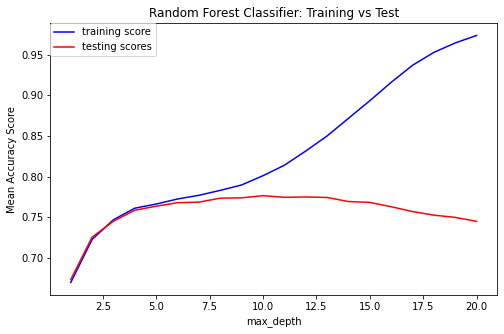

In [43]:
plt.figure(figsize = (8,5))
plt.plot([i for i in range(1,21)], train_scores, color = 'b', label= 'training score')
plt.plot([i for i in range(1,21)], test_scores, color = 'r', label='testing scores')
plt.xlabel('max_depth')
plt.ylabel('Mean Accuracy Score')
plt.title('Random Forest Classifier: Training vs Test')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model_TrainVsTest.png')

The gridsearch cross validation from prior gave a max_depth of 6. Based off this chart, it looks like 6 is still a good estimate without complete overfitting such as when the max_depth value is 13. We will go with our best estimators from the grid search.

#### Build Model

In [56]:
# Build Model with the best estimator parameters provided from the gridsearch CV
model = RandomForestClassifier(random_state=1234, n_estimators = 50, max_depth=6)
model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)

# Obtain the accuracy score, f1 score and confusion matrix: ac, f1, cm
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# print results
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Random Forest: Accuracy=0.769
Random Forest: f1-score=0.763
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9305
           1       0.74      0.61      0.67      5695

    accuracy                           0.77     15000
   macro avg       0.76      0.74      0.74     15000
weighted avg       0.77      0.77      0.76     15000



#### Importance of each feature

13


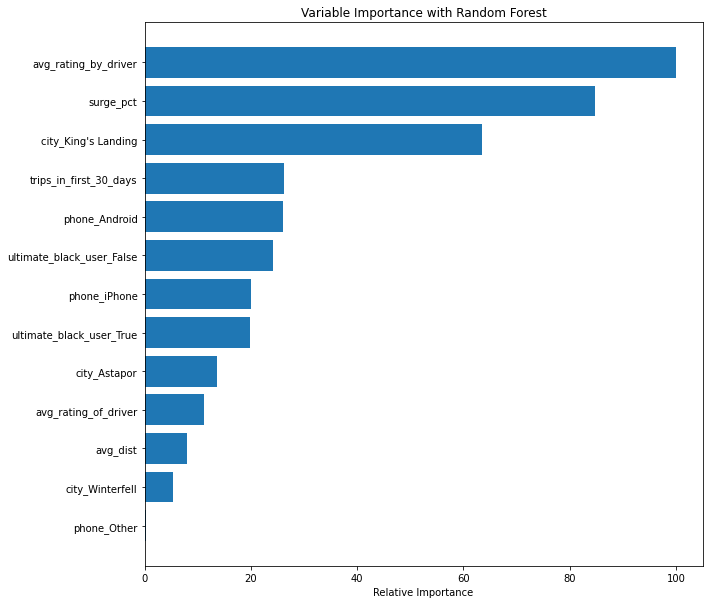

In [57]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Random Forest')
plt.show()

While the interaction between the features is complex, we see three features that are particurly important for the model: 'avg_rating_by_driver', 'surge_pct' and 'city_King's Landing'. 

## How Ultimate can use the Model and Results

1. From the exploratory analysis, we were able to identify peak times for rider log in. Particularly, during the late night to early mornings on weekends and around noon and around 10pm on weekdays. If we were to have a cheaper rates during the weekends, it could incentivize use the app more on weekends. 
2. Ultimate can use our model to predict whether a user will be active in their six month of use. Additionally, our model ourputs a barplot of the importance of each feature.
3. Lastly, our model has an f-1 score of 0.763 without overfitting. We suggest using the model as a final voice of reason when you are not entirely sure if a user will drop out in the next six months. 